# Прогнозирование ВВП Ганы

In [6]:

! pip install pmdarima arch

You should consider upgrading via the 'C:\Users\Дмитрий\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [7]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from arch import arch_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from warnings import filterwarnings
filterwarnings('ignore')
%matplotlib inline

In [8]:

# Загрузим данные.
data = pd.read_csv('ghana_gdp.csv', parse_dates=['year'], index_col=['year']) 
# Выведем для просмотра.
display(data.tail())

,GDP (current US$)
year,
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10
2020-01-01,7.004320e+10
2021-01-01,7.759428e+10


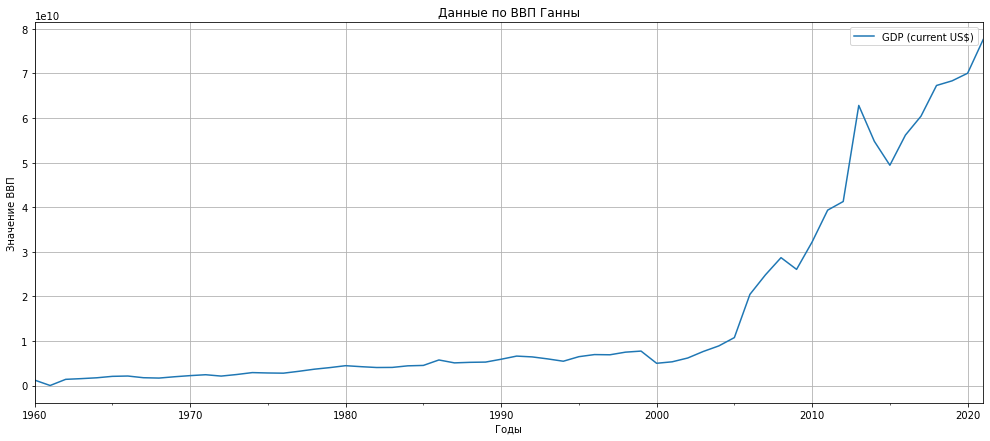

In [9]:

# Строим график.
data['GDP (current US$)'].plot(
    kind='line', 
    figsize=(17, 7), 
    legend=True, 
    title='Данные по ВВП Ганны', 
    grid=True, 
    xlabel='Годы', 
    ylabel='Значение ВВП'
);
     

### На графике видно, что тренд возрастающий на всем продяжении, но приблизительно с 2000 года рост стремительно увеличился..

In [10]:

# Разделим данные на тренировочную и тестовые выборки.
data_train = data[:'2018-01-01']
data_test = data['2019-01-01':]

# Выведем размерности выборок.
print(data_train.shape, data_test.shape)

(59, 1) (3, 1)


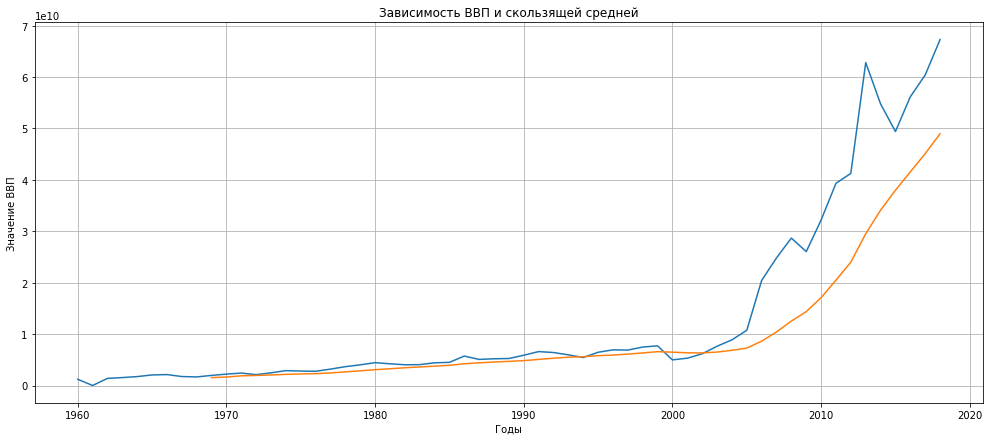

In [11]:

# Создадим фигуру и ось координат.
fig, ax = plt.subplots(figsize=(17, 7))
# Отобразим тренировочную выборку.
ax.plot(data_train)
# Отобразим скользящую среднюю с периодом 200.
ax.plot(data_train.rolling(window=10).mean())
ax.set_title('Зависимость ВВП и скользящей средней')
ax.set_xlabel('Годы')
ax.set_ylabel('Значение ВВП')
ax.grid()

## На графике видно, что если значение ВВП находится выше скользящей средней и наклон ее вверх, то график растет.

# Декомпозиция.

In [12]:

# Производим декомпозицию временного ряда.
decomposition = seasonal_decompose(data_train)

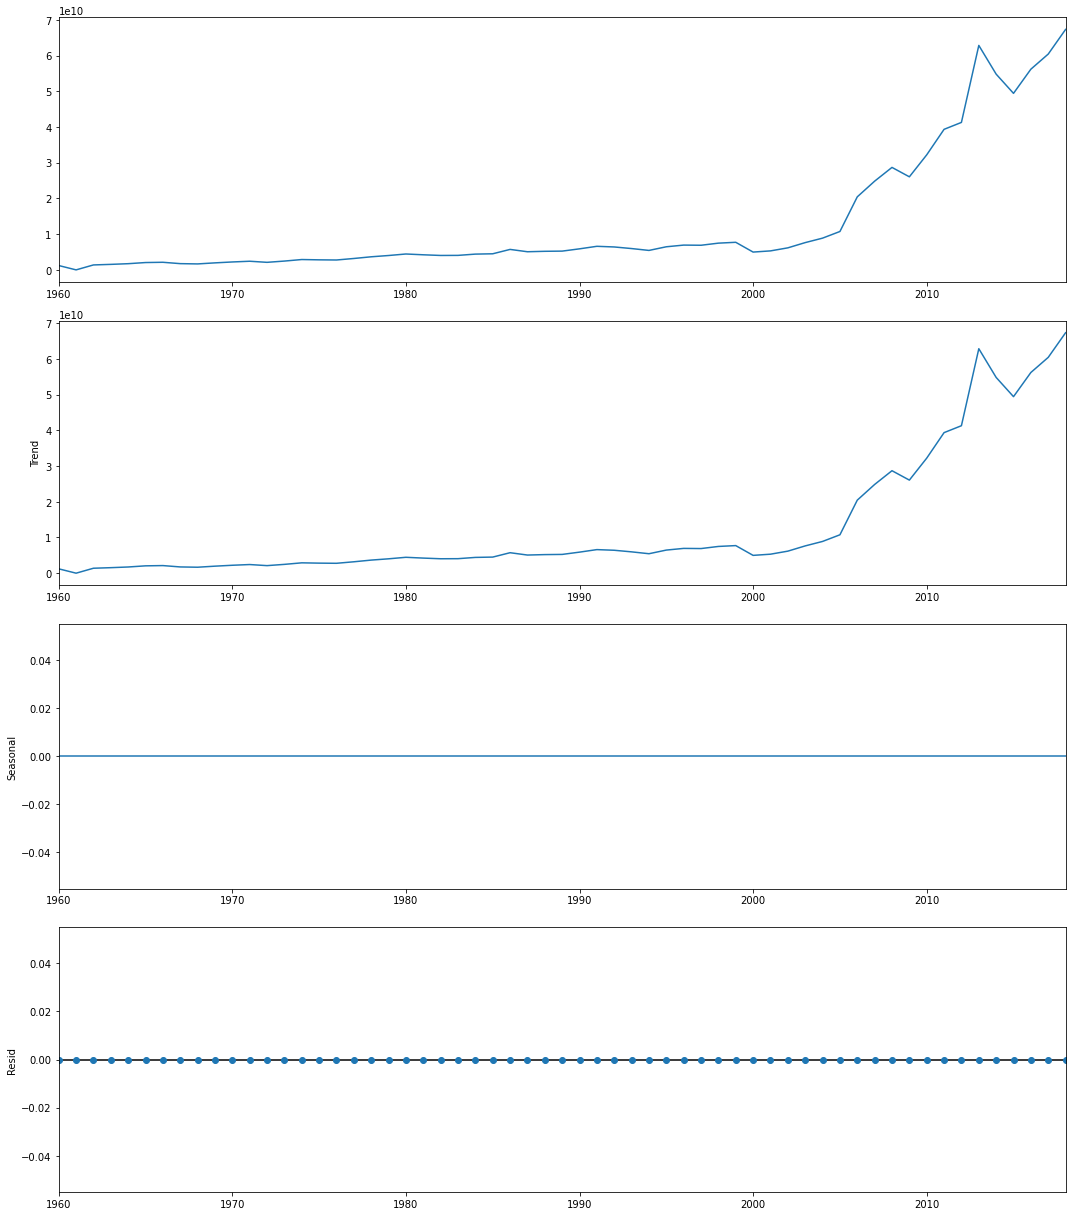

In [13]:

# Строим график.
plt.rcParams['figure.figsize'] = 15, 17
decomposition.plot()
plt.show()

### Исходя из графиков, можно сказать, что есть только восходящий тренд.

### Так как нам надо сделать долгосрочный прогноз, то будем проверять ряд на стационарность.

# Стационарность временного ряда

In [14]:

# Проверим стационарность ряда.
def stat_test(df):

    test = adfuller(df)
    
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])

    if test[0] > test[4]['5%']: 
        print ('Есть единичные корни, ряд не стационарен.')

    else:
        print ('Единичных корней нет, ряд стационарен.')

stat_test(data_train)

adf:  0.6529066974885367
p-value:  0.9888496277665573
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Есть единичные корни, ряд не стационарен.


In [16]:
# Для определения порядка интегрированного ряда получим новый ряд посредством взятия разности.
data_train_diff_1 = data_train.diff().dropna()

# Проверим на стационарность.
stat_test(data_train_diff_1)

adf:  -1.670248303832079
p-value:  0.4465029329713883
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
Есть единичные корни, ряд не стационарен.


In [17]:

# Для определения порядка интегрированного ряда получим новый ряд посредством взятия разности.
data_train_diff_2 = data_train_diff_1.diff().dropna()

# Проверим на стационарность.
stat_test(data_train_diff_2)

adf:  -2.640869056128483
p-value:  0.08484116917837797
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
Есть единичные корни, ряд не стационарен.


In [18]:

# Для определения порядка интегрированного ряда получим новый ряд посредством взятия разности.
data_train_diff_3 = data_train_diff_2.diff().dropna()

# Проверим на стационарность.
stat_test(data_train_diff_3)
     

adf:  -4.779623784828528
p-value:  5.9483276402250296e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Единичных корней нет, ряд стационарен.


# Коррелограммы ACF и PACF

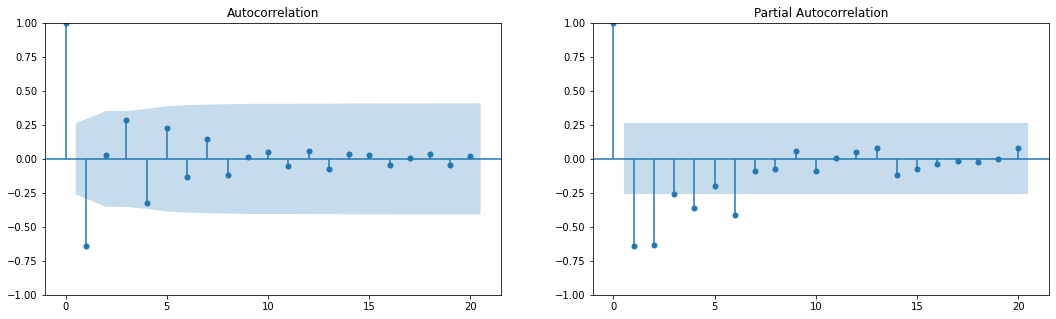

In [19]:
# Пстроим функцию для отображения графиков коррелограмм.
def plot_acf_pacf(series):

    plt.rcParams['figure.figsize'] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0], lags=20)
    sgt.plot_pacf(series, ax=axes[1], lags=20, method='ywm')
    plt.show()

# Отобразим графики. 
plot_acf_pacf(data_train_diff_3)
     

Из графика частичной автокорреляции берем значение   P=2  Q=1


# Модель ARIMA / SARIMAX

In [20]:

# Иницианализируем модель.
arima_model = ARIMA(data_train, order=(2, 3, 1))
# Обучаем модель.
arima_model_fit = arima_model.fit()
# Выводим результат.
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.615
Date:                Wed, 26 Apr 2023   AIC                           2659.231
Time:                        13:45:37   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.0

In [21]:

# Иницианализируем модель.
sarimax_model = SARIMAX(data_train, order=(2, 3, 1))
# Обучаем модель.
sarimax_model_fit = sarimax_model.fit()
# Выводим результат.
print(sarimax_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Wed, 26 Apr 2023   AIC                           2659.231
Time:                        13:45:51   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.0

# PAMDARIMA

# Подберем наилучшие параметры.

In [22]:
# Иницианализируем модель.
pamdarima_model = pm.auto_arima(
    data_train,
    start_p=1,
    d=3,
    start_q=1,
    max_p=3,
    max_q=3,
    max_d=3,
    D=3,
    start_P=0,
    # m=1,
    test='adf',
    error_action='ignore',
    trace=True,
)

# Выводим результат.
print(pamdarima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.03 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.02 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.03 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.01 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.04 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.02 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.03 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.446 seconds
                               SARIMAX Results                                
Dep. Variable:          

### Так как значения, подобранные PAMDARIMA приводят модель к таким же показателям 
### ,AIC BIC и HQIC , то оставим параметры (p=2, d=3, q=1) и предсказание будем осуществлять на них.

# Предсказание модели

In [23]:
# Построим датафрейм с индексами совподающими с тестовой выборкой.
pred_arima_model = pd.DataFrame(index=data.index)

# Создадим признак со значениями предсказания.
pred_arima_model['model_prediction'] = arima_model_fit.predict(
    start=data_test.index[0], 
    end=data_test.index[-1]
)
# Добавим признак.
pred_arima_model['GDP (current US$)'] = data['GDP (current US$)']

# Создадим 95%-ый доверительный интервал для прогноза.
forecast = arima_model_fit.get_forecast(len(data_test.index))
forecast_df = forecast.conf_int(alpha=0.05)

# Добавим признаки в датафрейм.
pred_arima_model.at[data_test.index, 'model_preds_lower'] = forecast_df['lower GDP (current US$)']
pred_arima_model.at[data_test.index, 'model_preds_upper'] = forecast_df['upper GDP (current US$)']

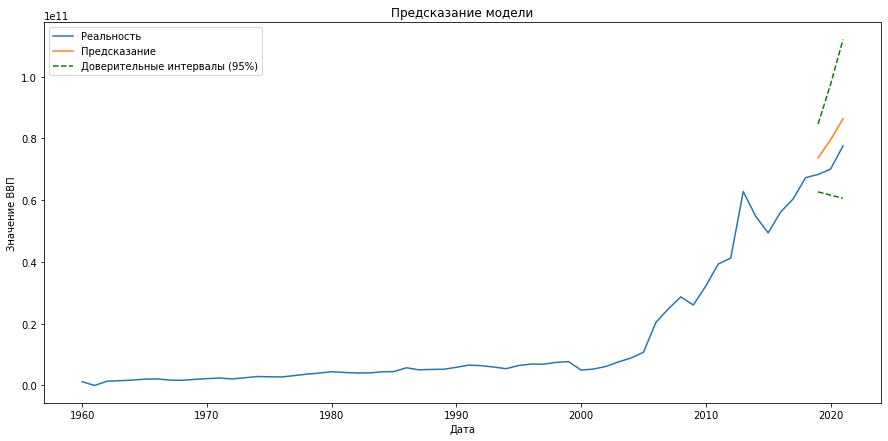

In [24]:
# Построим график предсказания.
fig = plt.figure(figsize=(15, 7))

fig = plt.plot(
    pred_arima_model['GDP (current US$)'],
    label='Реальность'
)

fig = plt.plot(
    pred_arima_model['model_prediction'],
    label='Предсказание'
)

fig = plt.plot(
    pred_arima_model.loc[data_test.index]['model_preds_lower'],
    color='green',
    linestyle='--',
    label='Доверительные интервалы (95%)'
)

fig = plt.plot(
    pred_arima_model.loc[data_test.index]['model_preds_upper'],
    color='green',
    linestyle='--'
)

plt.title('Предсказание модели')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Значение ВВП');

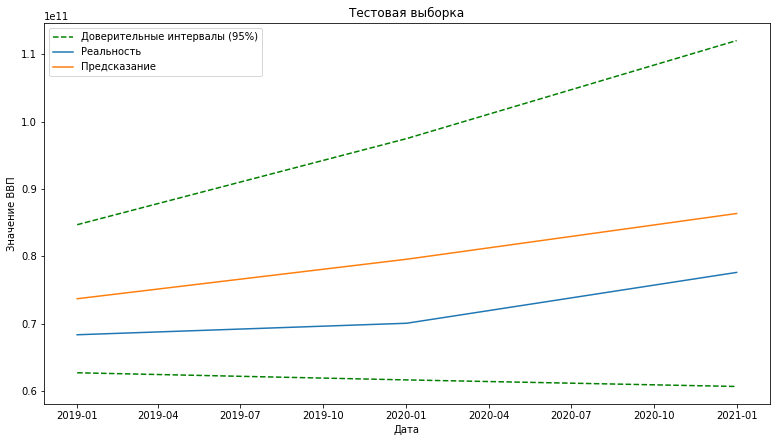

In [25]:
# Построим график интервалов.
fig = plt.figure(figsize=(13, 7))

fig = plt.plot(
    pred_arima_model.loc[data_test.index]['model_preds_lower'],
    color='green',
    linestyle='--',
    label='Доверительные интервалы (95%)'
)

fig = plt.plot(
    pred_arima_model.loc[data_test.index]['model_preds_upper'],
    color='green',
    linestyle='--'
)

fig = plt.plot(
    pred_arima_model.loc[data_test.index]['GDP (current US$)'],
    label='Реальность'
)

fig = plt.plot(
    pred_arima_model.loc[data_test.index]['model_prediction'],
    label='Предсказание'
)

plt.title('Тестовая выборка')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Значение ВВП');
     


### Из графиков видно, что модель поймала восходящий тренд, а сам показатель получился больше в предсказании.

# Downsampling / Upsampling / Интерполяция

In [30]:

# Проверим данные на наличие пропущенных дат.
df = data.asfreq(freq='AS')

# Сделаем проверку на наличие нулевых значений и в случае нахождения заменим их на NaN.
df['GDP (current US$)'] = df['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)

# Проверим данные на наличие пропущенных значений.
print('Количество пропущенных значений -', df.isnull().sum())

Количество пропущенных значений - GDP (current US$)    1
dtype: int64


In [31]:

# Для заполнения пропусков выполните интерполяцию.
df = df['GDP (current US$)'].interpolate(method='linear')

# Проверим данные на наличие пропущенных значений.
print('Количество пропущенных значений -', df.isnull().sum())

Количество пропущенных значений - 0


In [32]:

# Преобразуем в датафрейм.
df = pd.DataFrame(df)

In [33]:

# Разделим данные на тренировочную и тестовые выборки.
df_train = df[:'2018-01-01']
df_test = df['2019-01-01':]

# Стационарность временного ряда

In [34]:

# Проверим стационарность ряда.
def stat_test(df):

    test = adfuller(df)
    
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])

    if test[0] > test[4]['5%']: 
        print ('Есть единичные корни, ряд не стационарен.')

    else:
        print ('Единичных корней нет, ряд стационарен.')

stat_test(df)

adf:  2.380848757555631
p-value:  0.99900101016983
Critical values:  {'1%': -3.542412746661615, '5%': -2.910236235808284, '10%': -2.5927445767266866}
Есть единичные корни, ряд не стационарен.


In [35]:

# Для определения порядка интегрированного ряда получим новый ряд посредством взятия разности.
df_diff_1 = df_train.diff().dropna()

# Проверим на стационарность.
stat_test(df_diff_1)

adf:  -1.8255652246436056
p-value:  0.3678451527656314
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
Есть единичные корни, ряд не стационарен.


In [36]:
# Для определения порядка интегрированного ряда получим новый ряд посредством взятия разности.
df_diff_2 = df_diff_1.diff().dropna()

# Проверим на стационарность.
stat_test(df_diff_2)
     

adf:  -2.634634746007848
p-value:  0.08604813722197563
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
Есть единичные корни, ряд не стационарен.


In [37]:

# Для определения порядка интегрированного ряда получим новый ряд посредством взятия разности.
df_diff_3 = df_diff_2.diff().dropna()

# Проверим на стационарность.
stat_test(df_diff_3)

adf:  -4.825603687304028
p-value:  4.8573180767997966e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Единичных корней нет, ряд стационарен.


# Коррелограммы ACF и PACF

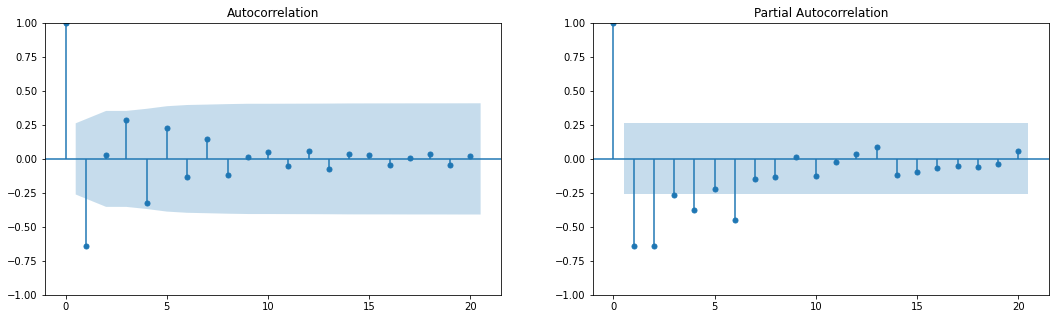

In [38]:

# Отобразим графики. 
plot_acf_pacf(df_diff_3)


### Из графика частичной автокорреляции берем значение 
### p=2 и  q=1


# Модель ARIMA / SARIMAX

In [39]:

# Иницианализируем модель.
arima_model = ARIMA(df_train, order=(2, 3, 1))
# Обучаем модель.
arima_model_fit = arima_model.fit()
# Выводим результат.
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.613
Date:                Wed, 26 Apr 2023   AIC                           2659.226
Time:                        13:50:54   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.0

In [40]:

# Иницианализируем модель.
sarimax_model = SARIMAX(df_train, order=(2, 3, 1))
# Обучаем модель.
sarimax_model_fit = sarimax_model.fit()
# Выводим результат.
print(sarimax_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.613
Date:                Wed, 26 Apr 2023   AIC                           2659.226
Time:                        13:51:07   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.0

### После интерполяции временного ряда значения ,AIC  BIC и HQIC   не изменились.

# Предсказание модели

In [41]:
# Построим датафрейм с индексами совподающими с тестовой выборкой.
pred_arima_model = pd.DataFrame(index=df.index)

# Создадим признак со значениями предсказания.
pred_arima_model['model_prediction'] = arima_model_fit.predict(
    start=df_test.index[0], 
    end=df_test.index[-1]
)
# Добавим признак.
pred_arima_model['GDP (current US$)'] = df['GDP (current US$)']

# Создадим 95%-ый доверительный интервал для прогноза.
forecast = arima_model_fit.get_forecast(len(df_test.index))
forecast_df = forecast.conf_int(alpha=0.05)

# Добавим признаки в датафрейм.
pred_arima_model.at[data_test.index, 'model_preds_lower'] = forecast_df['lower GDP (current US$)']
pred_arima_model.at[data_test.index, 'model_preds_upper'] = forecast_df['upper GDP (current US$)']

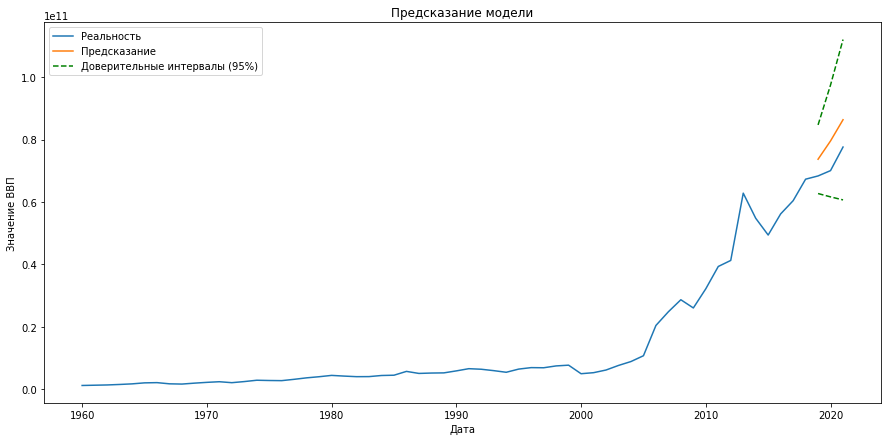

In [43]:
# Построим график предсказания.
fig = plt.figure(figsize=(15, 7))

fig = plt.plot(
    pred_arima_model['GDP (current US$)'],
    label='Реальность'
)

fig = plt.plot(
    pred_arima_model['model_prediction'],
    label='Предсказание'
)

fig = plt.plot(
    pred_arima_model.loc[df_test.index]['model_preds_lower'],
    color='green',
    linestyle='--',
    label='Доверительные интервалы (95%)'
)

fig = plt.plot(
    pred_arima_model.loc[df_test.index]['model_preds_upper'],
    color='green',
    linestyle='--'
)

plt.title('Предсказание модели')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Значение ВВП');

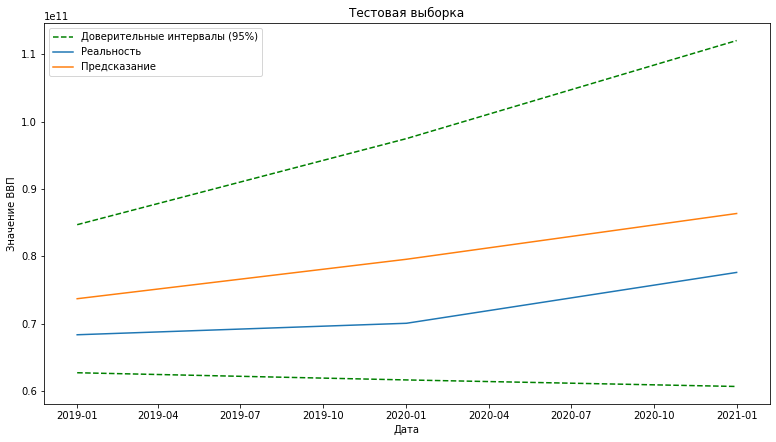

In [44]:
# Построим график интервалов.
fig = plt.figure(figsize=(13, 7))

fig = plt.plot(
    pred_arima_model.loc[data_test.index]['model_preds_lower'],
    color='green',
    linestyle='--',
    label='Доверительные интервалы (95%)'
)

fig = plt.plot(
    pred_arima_model.loc[data_test.index]['model_preds_upper'],
    color='green',
    linestyle='--'
)

fig = plt.plot(
    pred_arima_model.loc[data_test.index]['GDP (current US$)'],
    label='Реальность'
)

fig = plt.plot(
    pred_arima_model.loc[data_test.index]['model_prediction'],
    label='Предсказание'
)

plt.title('Тестовая выборка')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Значение ВВП');

###  ничего не изменилось.

# Волатильность

In [45]:
df['volatility'] = df['GDP (current US$)'].pct_change(1).mul(100).abs()
df['volatility'].head()

year
1960-01-01          NaN
1961-01-01     6.789413
1962-01-01     6.357759
1963-01-01    11.448835
1964-01-01    12.363636
Freq: AS-JAN, Name: volatility, dtype: float64

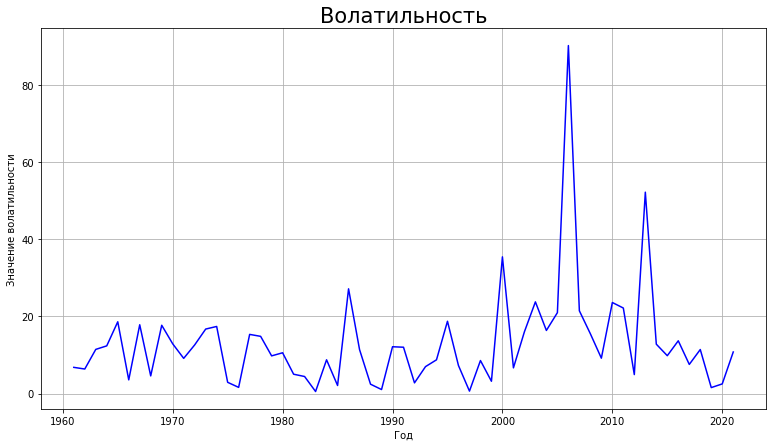

In [46]:
# Визуализируем волатильность.
fig = plt.figure(figsize=(13, 7))

plt.plot(df['volatility'], c='blue')
plt.title('Волатильность', size=21)
plt.xlabel('Год')
plt.ylabel('Значение волатильности')
plt.grid();

In [47]:
# Разделим данные на тренировочную и тестовые выборки.
df_train = df[:'2010-01-01']
df_test = df['2011-01-01':]

# Стационарность временного ряда

In [48]:

# Проверим на стационарность.
stat_test(df_train.volatility[1:])

adf:  -5.832296782652173
p-value:  3.949228653445448e-07
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
Единичных корней нет, ряд стационарен.


# Коррелограммы ACF и PACF

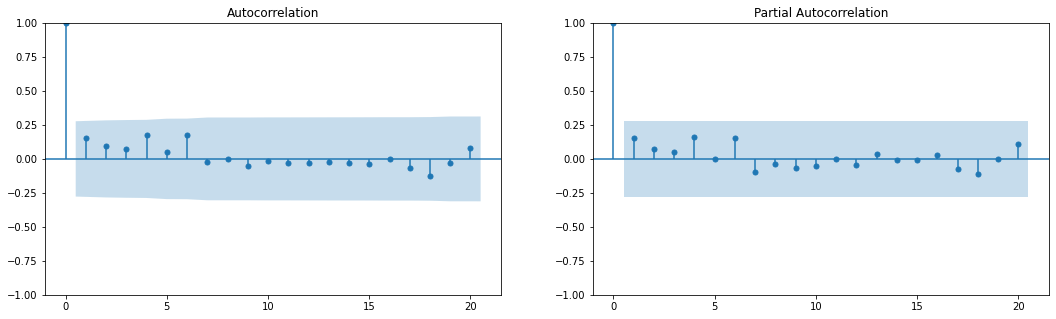

In [49]:

# Отобразим графики. 
plot_acf_pacf(df_train.volatility[1:])

### Из графика частичной автокорреляции берем значение  p=1 и q=1.

# Модель ARCH

In [50]:

# Нам важно сохранить объем датасета, поэтому берем за исходные данные 
# весь датасет с индексами, который содержит и train и test часть.
garch_df = pd.DataFrame(df['volatility'])
     

In [51]:

# Иницианализируем модель.
model = arch_model(garch_df['volatility'].dropna(), p=1, q=1)

# В параметре last_obs указываем последний объект, до которого будем совершать обучение.
# В нашем случае это до первого объекта из test выборки
model_results = model.fit(last_obs=df_test.index[0], update_freq=5)

Iteration:      5,   Func. Count:     27,   Neg. LLF: 193.66096978324273
Iteration:     10,   Func. Count:     53,   Neg. LLF: 193.0918965848066
Optimization terminated successfully    (Exit mode 0)
            Current function value: 193.0918965848066
            Iterations: 11
            Function evaluations: 57
            Gradient evaluations: 11


In [52]:

# Выводим результат.
print(model_results.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             volatility   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -193.092
Distribution:                  Normal   AIC:                           394.184
Method:            Maximum Likelihood   BIC:                           401.832
                                        No. Observations:                   50
Date:                Wed, Apr 26 2023   Df Residuals:                       49
Time:                        13:52:29   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.8536      2.293      5.169  2.350e-07 [  7.359, 16.34

# Предсказание модели

In [53]:

# Создадим копию тестовой выборки.
pred_df = df_test.copy()

# Создадим признак со значениями предсказания.
pred_df['predictions'] = model_results.forecast().residual_variance.loc[df_test.index]

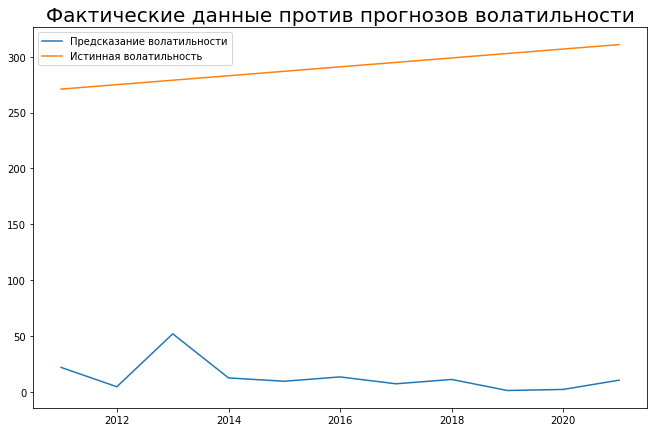

In [54]:

# Построим графики.
fig = plt.figure(figsize=(11, 7))

plt.plot(
    pred_df['volatility'], 
    label='Предсказание волатильности'
)

plt.plot(
    pred_df['predictions'], 
    label='Истинная волатильность'
)

plt.title('Фактические данные против прогнозов волатильности', size=20)
plt.legend();

In [55]:

# Выведем значение метрики.
print('Показание метрики - {:.3f}'.format(mean_squared_error(pred_df['volatility'], pred_df['predictions'])))
     

Показание метрики - 77375.146


### Судя по полученному графику и метрике, модель не уловила дисперсию, так как такое поведение было для неё новым и подобные случаи отсутствовали в обучающей выборке. Необходимо больше данных, которые показывают разные ситуации.

# Модель LinearRegression

In [56]:

# Разобьем данные на тестовые и обучающие выборки.
X_train = pd.DataFrame(range(df['volatility'].shape[0]))[
    : df_train.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(df['volatility'].shape[0]))[
    df_train.shape[0] :
].fillna(0)
y_train = df_train['volatility'].fillna(0)
y_test =df_test['volatility'].fillna(0)

In [50]:
# Иницианализируем модель.
lr = LinearRegression()
# Обучим модель.
lr.fit(X_train, y_train)
# Сделаем предсказание.
lr_predict = lr.predict(X_test)
     

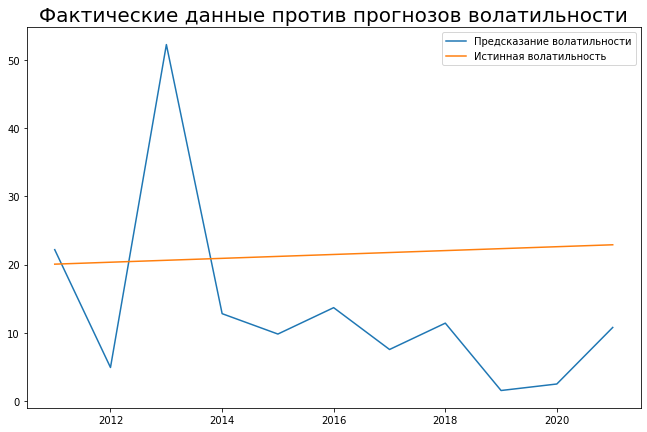

In [51]:

# Отобразим результат на графике.
fig = plt.figure(figsize=(11, 7))

plt.plot(
    y_test, 
    label='Предсказание волатильности'
)

plt.plot(
    pd.Series(lr_predict, index=y_test.index), 
    label='Истинная волатильность'
)

plt.title('Фактические данные против прогнозов волатильности', size=20)
plt.legend();

## Линейная регрессия оказалась ближе к реальным значения волатильности